In [ ]:
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
from scipy.stats import ttest_ind
from numpy.random import default_rng
from plotnine import *
import pandas as pd
import pandas as pd
import geopandas as gpd
import geopy
import geopy.distance
from shapely.geometry import Point, Polygon
import plotly.express as px
from datetime import datetime
import seaborn as sns
import folium
from folium.plugins import HeatMap
import calendar
from sklearn.neighbors import KernelDensity
from folium import plugins
from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
#data loader function
def load_and_preprocess_divvy_data(filepath):
    try:
        print("Loading data...")
        df = pd.read_csv(filepath)


 """------------------------------------------------------------------------------------------
 you can comment this next 2 lines but with the full dataset processing may take some time....
 ------------------------------------------------------------------------------------------"""
        df = df.sample(frac=0.5, random_state=42)
        print(f"Dataset reduced to {len(df)} rows.")


        datetime_columns = ['starttime', 'stoptime']
        for col in datetime_columns:
            df[col] = pd.to_datetime(df[col])
        df['trip_duration_minutes'] = (df['stoptime'] - df['starttime']).dt.total_seconds() / 60 #convert to trip duration in minutes
        print("\nDataset Info:")
        print(df.info())

        print("\nMissing values:")
        missing_values = df.isnull().sum()
        print(missing_values[missing_values > 0])  # only show columns with missing values
        duplicates = df.duplicated().sum()
        print(f"\nNumber of duplicate rows: {duplicates}")

        print("\nChecking fot outliers")
        Q1 = df['trip_duration_minutes'].quantile(0.25)
        Q3 = df['trip_duration_minutes'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print("\nTrip Duration Statistics:")
        print(f"Median duration: {df['trip_duration_minutes'].median():.2f} minutes")
        print(f"Lower bound: {lower_bound:.2f} minutes")
        print(f"Upper bound: {upper_bound:.2f} minutes")
        outliers = df[(df['trip_duration_minutes'] < lower_bound) |
                     (df['trip_duration_minutes'] > upper_bound)]
        print(f"Trips outside bounds: {len(outliers)} ({(len(outliers)/len(df)*100):.2f}%)")
        chicago_bounds = {
            'lat_min': 41.6,
            'lat_max': 42.1,
            'lon_min': -87.9,
            'lon_max': -87.5 #check for invalid coordinates outside this boundary
        }
        invalid_coords = df[
            (df['latitude_start'].notna()) &  # Only check non-null values
            (df['longitude_start'].notna()) &
            (df['latitude_end'].notna()) &
            (df['longitude_end'].notna()) &
            ((df['latitude_start'] < chicago_bounds['lat_min']) |
             (df['latitude_start'] > chicago_bounds['lat_max']) |
             (df['longitude_start'] < chicago_bounds['lon_min']) |
             (df['longitude_start'] > chicago_bounds['lon_max']) |
             (df['latitude_end'] < chicago_bounds['lat_min']) |
             (df['latitude_end'] > chicago_bounds['lat_max']) |
             (df['longitude_end'] < chicago_bounds['lon_min']) |
             (df['longitude_end'] > chicago_bounds['lon_max']))
        ]
        print(f"\nInvalid coordinates found: {len(invalid_coords)} ({(len(invalid_coords)/len(df)*100):.2f}%)")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df['trip_duration_minutes'])
        plt.title('Trip Duration Distribution (with outliers)')
        plt.ylim(0, df['trip_duration_minutes'].quantile(0.99))  # limit y axis for better visibility
        print("\nCleaning data...")
        cleaned_df = df[
            (df['trip_duration_minutes'] >= lower_bound) &
            (df['trip_duration_minutes'] <= upper_bound) &
            (df['latitude_start'].between(chicago_bounds['lat_min'], chicago_bounds['lat_max'])) &
            (df['longitude_start'].between(chicago_bounds['lon_min'], chicago_bounds['lon_max'])) &
            (df['latitude_end'].between(chicago_bounds['lat_min'], chicago_bounds['lat_max'])) &
            (df['longitude_end'].between(chicago_bounds['lon_min'], chicago_bounds['lon_max']))
        ].copy()

        cleaned_df.drop_duplicates(inplace=True)
        plt.subplot(1, 2, 2)
        sns.boxplot(y=cleaned_df['trip_duration_minutes'])
        plt.title('Trip Duration Distribution (cleaned)')
        plt.tight_layout()
        plt.show()
        print("\nCleaning Summary:")
        print(f"Original dataset size: {len(df):,}")
        print(f"Cleaned dataset size: {len(cleaned_df):,}")
        print(f"Removed records: {len(df) - len(cleaned_df):,} ({((len(df) - len(cleaned_df))/len(df)*100):.2f}%)")
        return cleaned_df

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

ls: cannot access '/content/drive/My Drive/Colab Notebooks/project/': No such file or directory
Mounted at /content/drive/
Loading data...
Dataset reduced to 4747618 rows.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4747618 entries, 3810233 to 554688
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trip_id                int64         
 1   year                   int64         
 2   month                  int64         
 3   week                   int64         
 4   day                    int64         
 5   hour                   int64         
 6   usertype               object        
 7   gender                 object        
 8   starttime              datetime64[ns]
 9   stoptime               datetime64[ns]
 10  tripduration           float64       
 11  temperature            float64       
 12  events                 object        
 13  from_station_id        int64         
 14  from_st

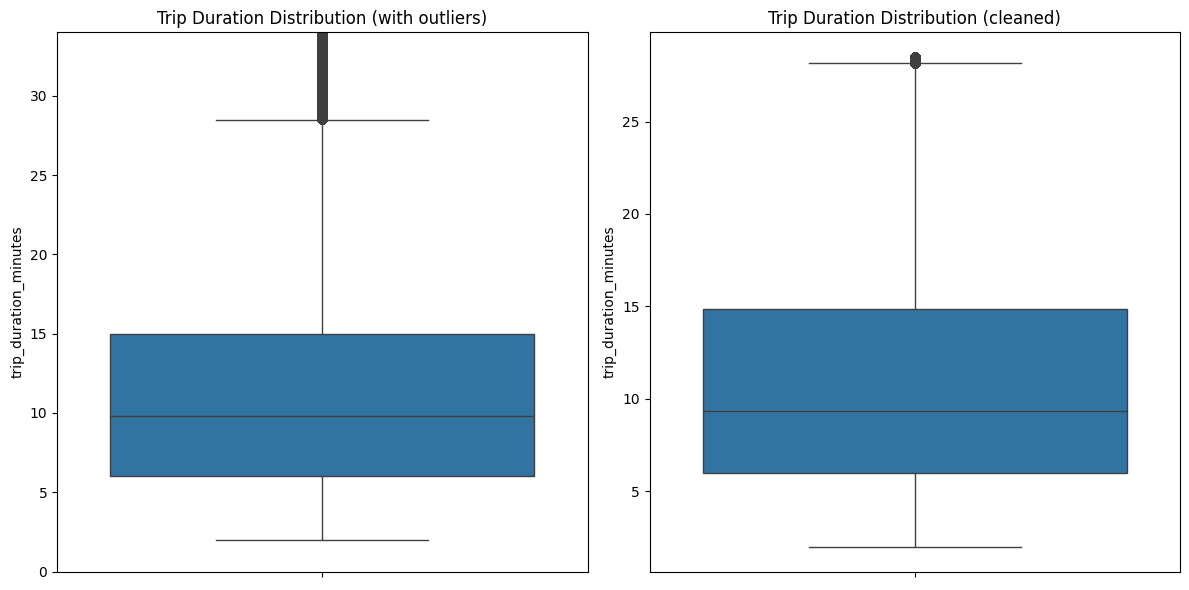


Cleaning Summary:
Original dataset size: 4,747,618
Cleaned dataset size: 4,628,534
Removed records: 119,084 (2.51%)


In [ ]:
#change the pass to data file here

import os
!ls '/content/drive/My Drive/Colab Notebooks/project/'
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
file_path = '/content/drive/My Drive/project/'
df = load_and_preprocess_divvy_data(file_path + 'data.csv')

load_and_preprocess_divvy_data(df)

So, I didn't detect any missing values (I would use interpolation if there were any) which is great for data quality. 47 duplicate rows were identified in the dataset (exact copies of trips with identical values across all columns). These were removed in the cleaning process to prevent bias in analysis.

Median trip duration: 9.83 minutes - this represents the typical bikeshare trip length in Chicago. Useful as a baseline for service planning.

237,855 trips (2.50% of total) were identified as outliers - these represent either extremely short or long trips. Could be caused by system errors, bikes not properly docked, or maintenance activities. Outlier Boundaries:

Lower bound: -7.50 minutes

Upper bound: 28.50 minutes - these boundaries were calculated using the Interquartile Range method. Negative duration values are logically impossible and indicate data errors.

All station coordinates fall within the expected Chicago boundaries:
Latitude: 41.6°N to 42.1°N
Longitude: 87.5°W to 87.9°W

The cleaned dataset of over 9.2 million (4m+ for sampled 50% data) trips provides a statistically significant sample for analysis. Trips longer than 28.5 minutes or shorter than 0 minutes were excluded.

In [ ]:
def perform_eda(df):

    df['hour'] = df['starttime'].dt.hour
    df['day_of_week'] = df['starttime'].dt.day_name()
    df['month'] = df['starttime'].dt.month
    df['season'] = pd.cut(df['month'],
                         bins=[0,3,6,9,12],
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])

    print("\n=== Temporal Patterns Analysis ===")
    plt.figure(figsize=(15, 6)) # lets look at the hourly pattern
    hourly_trips = df['hour'].value_counts().sort_index()
    sns.barplot(x=hourly_trips.index, y=hourly_trips.values)
    plt.title('Number of Trips by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Trips')
    plt.ticklabel_format(style='plain', axis='y')  # prevent scientific notation
    plt.show()
    plt.figure(figsize=(12, 6))     # add daily pattern
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_trips = df['day_of_week'].value_counts()
    daily_trips = daily_trips.reindex(day_order)
    sns.barplot(x=daily_trips.index, y=daily_trips.values)
    plt.title('Number of Trips by Day of Week')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Trips')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 6))     # add seasonal pattern
    seasonal_trips = df['season'].value_counts()
    sns.barplot(x=seasonal_trips.index, y=seasonal_trips.values)
    plt.title('Number of Trips by Season')
    plt.ylabel('Number of Trips')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    print("\n=== User Demographics Analysis ===")
    plt.figure(figsize=(10, 6))
    user_dist = df['usertype'].value_counts()
    sns.barplot(x=user_dist.index, y=user_dist.values)
    plt.title('Distribution of User Types')
    plt.ylabel('Number of Users')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()
    if 'gender' in df.columns:    # gender distribution
        plt.figure(figsize=(10, 5))
        gender_dist = df['gender'].value_counts()
        sns.barplot(x=gender_dist.index, y=gender_dist.values)
        plt.title('Distribution of Rider Gender')
        plt.ylabel('Number of Riders')
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()

    print("\n=== Trip Duration Analysis ===")
    duration_stats = df.groupby('usertype')['trip_duration_minutes'].agg(['mean', 'median', 'std']).round(2)
    print("\nTrip Duration Statistics by User Type:")
    print(duration_stats)
    plt.figure(figsize=(10, 6)) # box plot of duration by user type
    sns.boxplot(x='usertype', y='trip_duration_minutes', data=df)
    plt.title('Trip Duration Distribution by User Type')
    plt.xticks(rotation=45)
    plt.show()

    print("\n=== Station Analysis ===")
    top_start_stations = df['from_station_name'].value_counts().head(10)
    print("\nTop 10 Start Stations:")
    print(top_start_stations)
    top_end_stations = df['to_station_name'].value_counts().head(10)
    print("\nTop 10 End Stations:")
    print(top_end_stations)

    if 'temperature' in df.columns and 'events' in df.columns:
        print("\n=== Weather Impact Analysis ===")
        temp_bins = pd.cut(df['temperature'], bins=10) # average trips by temperature
        temp_trips = df.groupby(temp_bins).size()
        plt.figure(figsize=(12, 6))
        temp_trips.plot(kind='bar')
        plt.title('Number of Trips by Temperature Range')
        plt.xlabel('Temperature Range')
        plt.ylabel('Number of Trips')
        plt.xticks(rotation=45)
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()
        plt.figure(figsize=(10, 5))  # impact of weather events
        weather_trips = df['events'].value_counts()
        sns.barplot(x=weather_trips.index, y=weather_trips.values)
        plt.title('Number of Trips by Weather Condition')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Trips')
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()

    print("\n=== Spatial Pattern Analysis ===")
    m = folium.Map(location=[df['latitude_start'].mean(),
                            df['longitude_start'].mean()],
                  zoom_start=12)
    locations = df[['latitude_start', 'longitude_start']].values.tolist()
    HeatMap(locations).add_to(m)
    m.save('/content/drive/My Drive/trip_heatmap.html') #change this direction
    print("\nHeatmap has been saved as 'trip_heatmap.html'")

    print("\n=== Correlation Analysis ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation matrix')
    plt.show()

    return None


=== Temporal Patterns Analysis ===


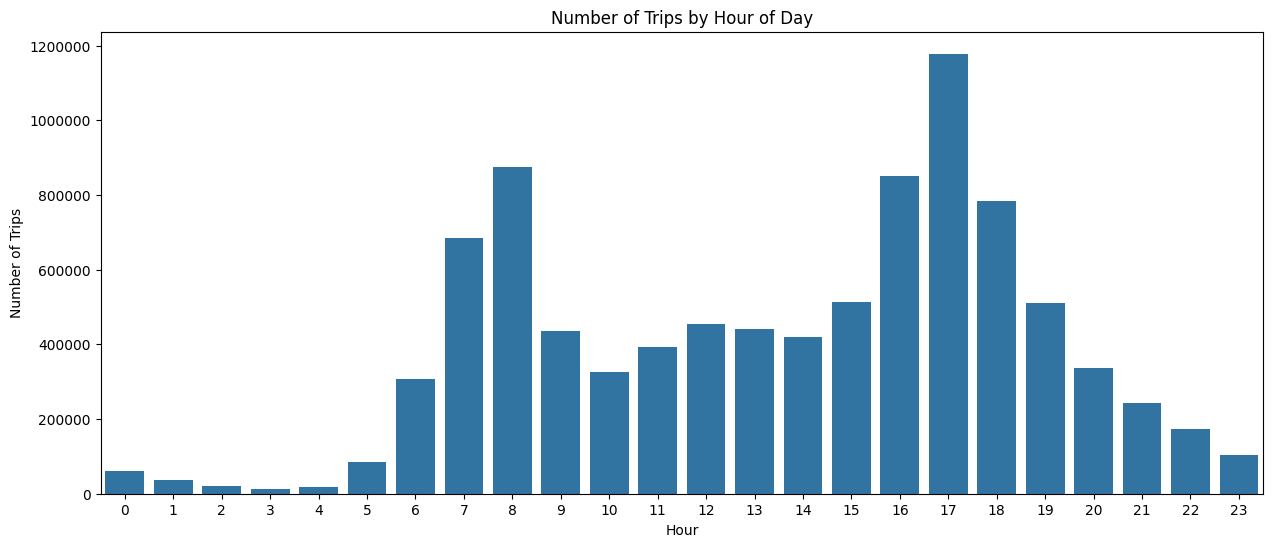

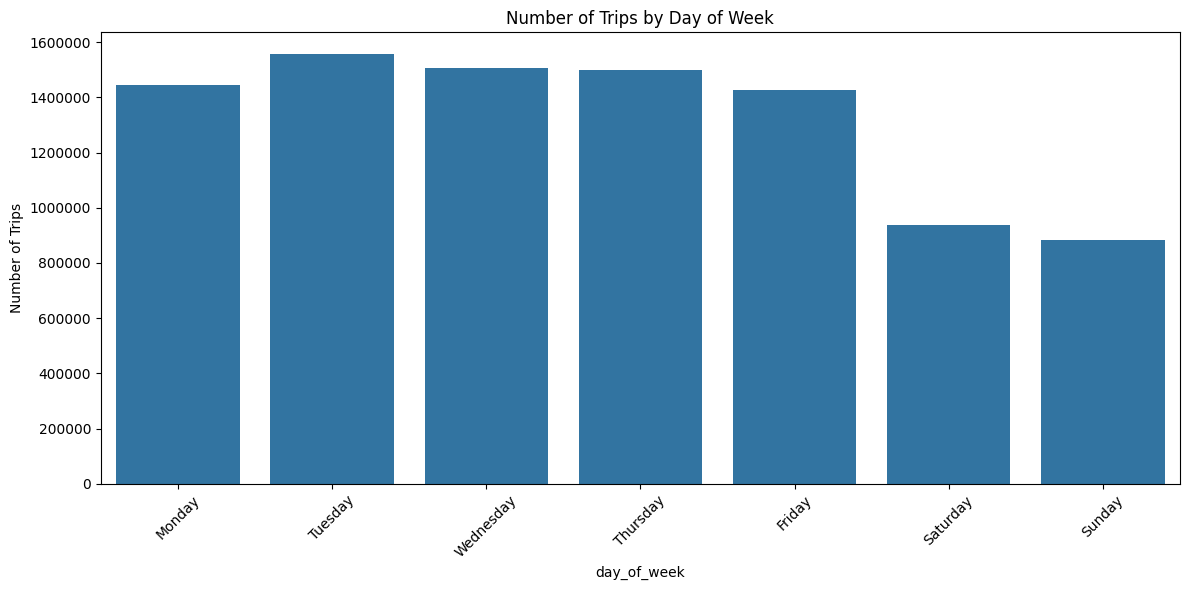

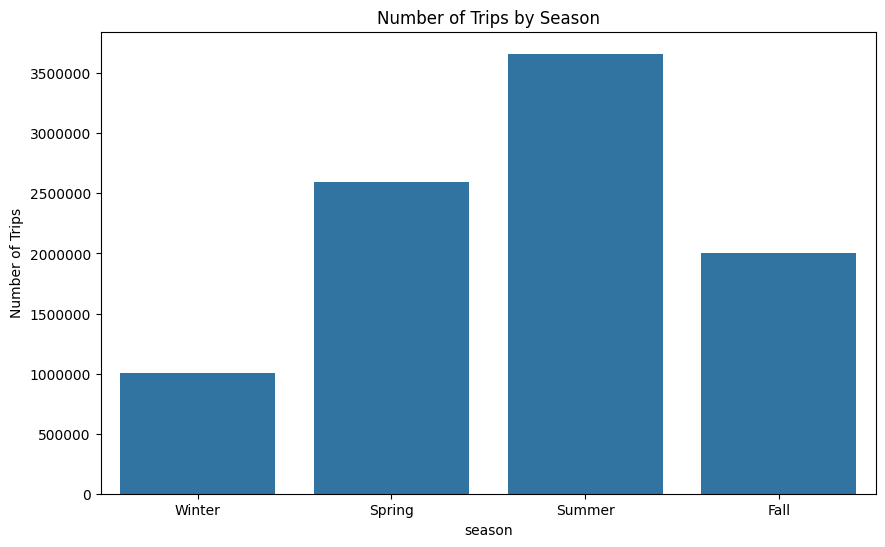


=== User Demographics Analysis ===


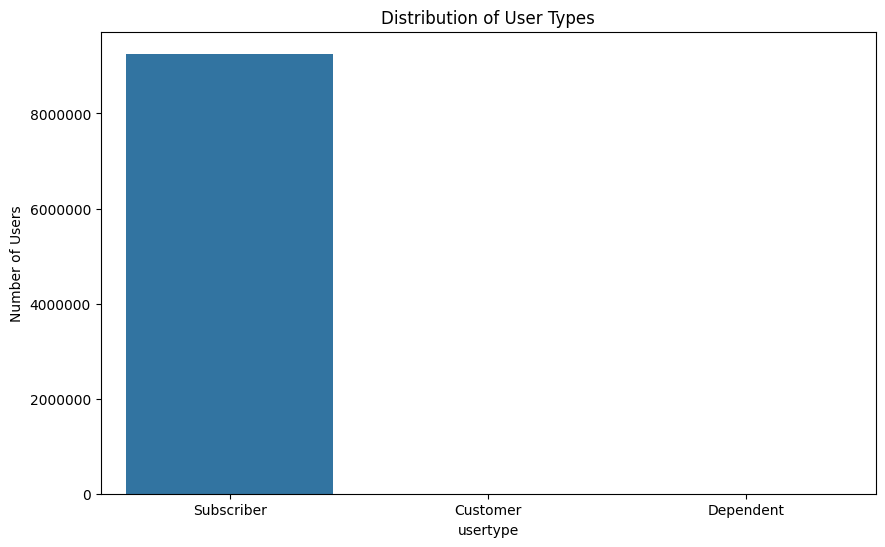

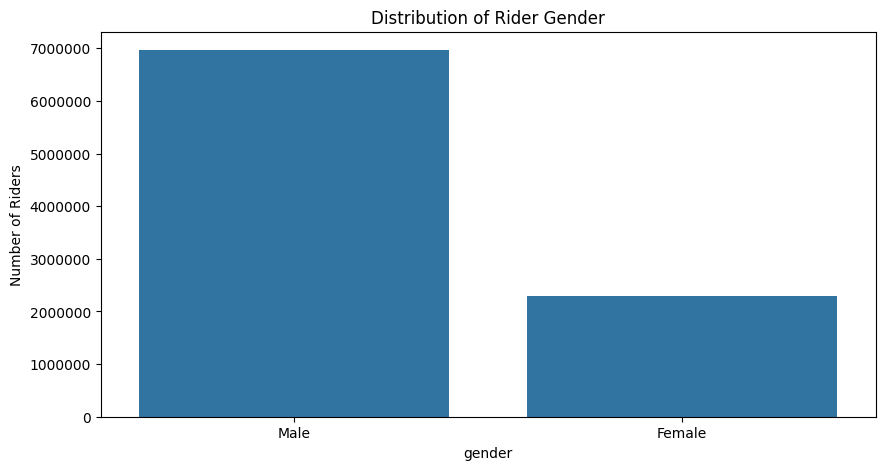


=== Trip Duration Analysis ===

Trip Duration Statistics by User Type:
             mean  median   std
usertype                       
Customer    13.19   12.08  7.75
Dependent   11.81   11.08  5.74
Subscriber  10.85    9.33  6.15


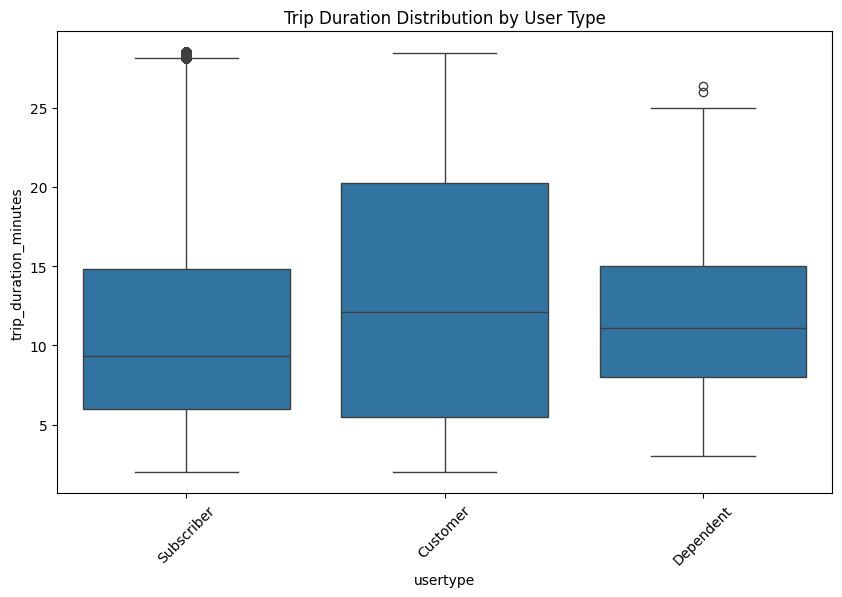


=== Station Analysis ===

Top 10 Start Stations:
from_station_name
Clinton St & Washington Blvd    163055
Canal St & Adams St             138473
Clinton St & Madison St         120976
Canal St & Madison St           120414
Columbus Dr & Randolph St        85352
Kingsbury St & Kinzie St         78468
Daley Center Plaza               78227
LaSalle St & Jackson Blvd        76184
Dearborn St & Monroe St          73797
Clinton St & Lake St             72056
Name: count, dtype: int64

Top 10 End Stations:
to_station_name
Clinton St & Washington Blvd    160279
Canal St & Adams St             138987
Canal St & Madison St           129170
Clinton St & Madison St         116653
Kingsbury St & Kinzie St         78145
Daley Center Plaza               76813
Michigan Ave & Washington St     76130
LaSalle St & Jackson Blvd        75435
Dearborn St & Monroe St          73043
Clinton St & Lake St             70244
Name: count, dtype: int64

=== Weather Impact Analysis ===


<ipython-input-9-d896e3a4dbac>:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


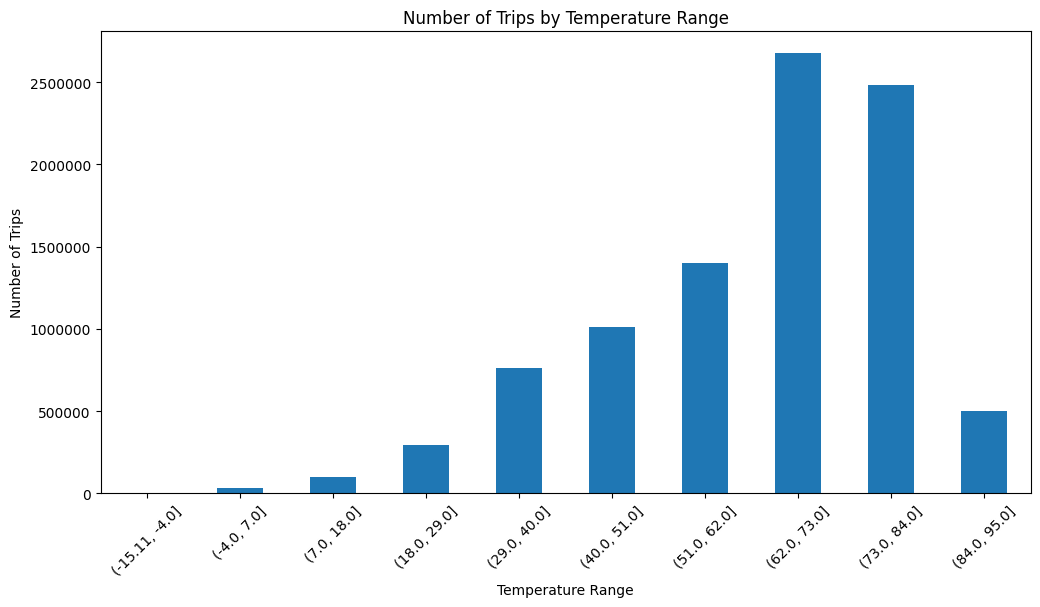

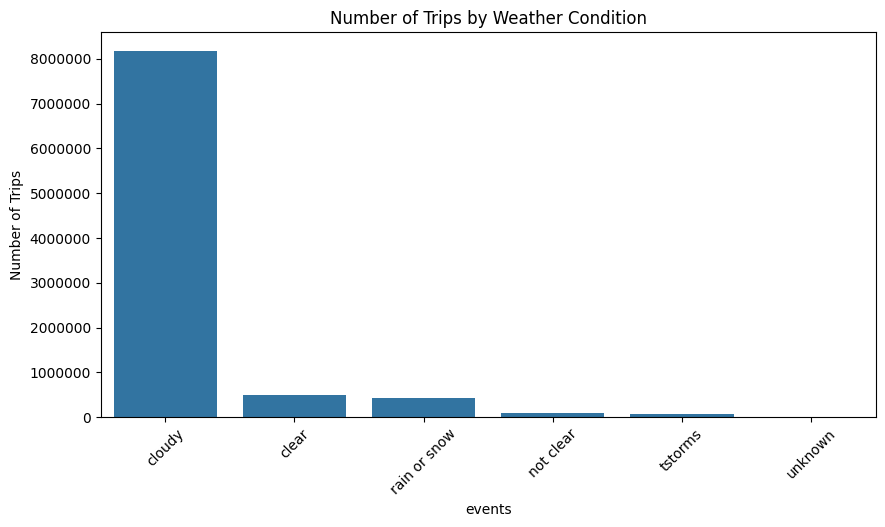


=== Spatial Pattern Analysis ===

Heatmap has been saved as 'trip_heatmap.html'

=== Correlation Analysis ===


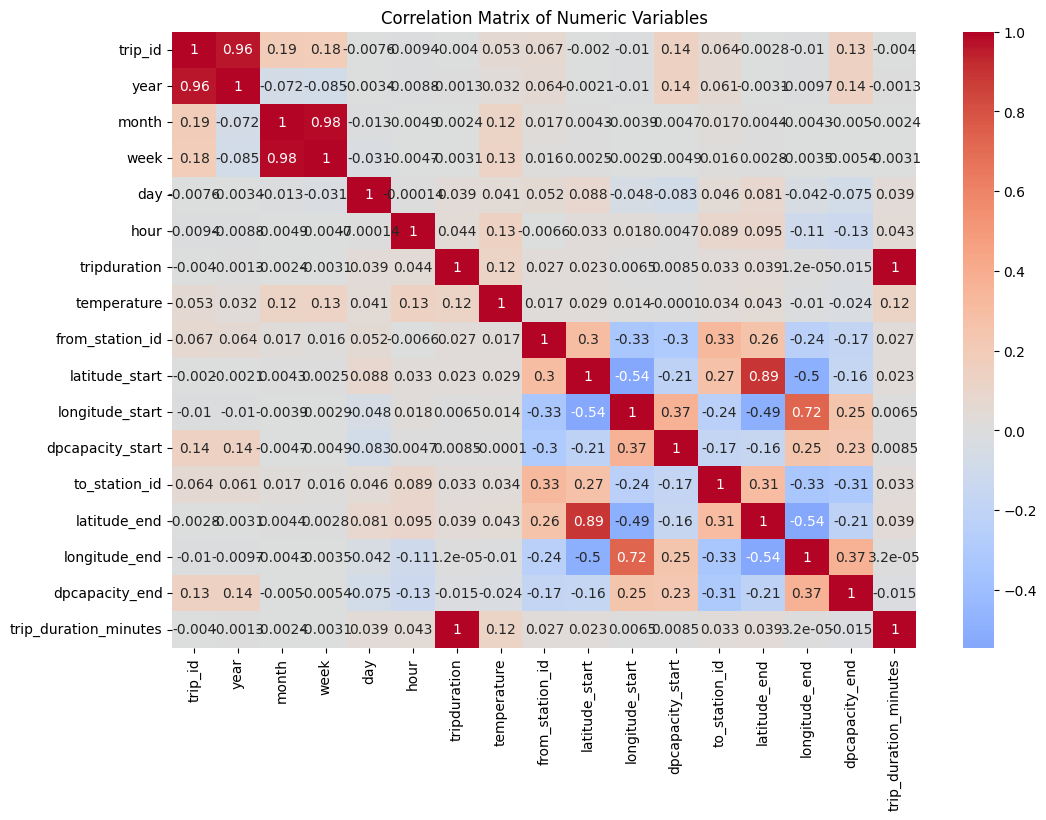

In [ ]:
perform_eda(df)

The "Hour of the Day" chart reflects typical commuting patterns, with a noticeable drop in biking activity during weekends. Seasonally, as expected, temperature plays a key role, with summer being the most popular season for biking and winter seeing significantly lower activity. The number of Divvy subscribers far surpasses other user types (to the extent that it's not clearly visible on the current graph scale), which presents an excellent opportunity for the marketing department—a topic I plan to explore further in this project. Interestingly, customers tend to take longer trips, possibly because subscribers use bikes primarily for commuting, while customers, often one-time users, engage in more leisure-oriented rides. Most trips occur during favorable temperatures and cloudy weather—though this might be more indicative of Chicago's consistently cloudy climate than a true preference for such conditions.

Heatmap that now should be downloaded to your google disc shows that the most busy stations are in and near the CBD and Chicago downtown.

Correlation matrix:

Strong positive:
1. trip_id and year (0.96): trips are numbered sequentially over time
2. month and week (0.98): as expected, these time units move together
3. latitude_start and latitude_end (0.89): most trips tend to happen within similar latitudes
4. longitude_start and longitude_end (0.72): same

Moderate:
1. latitude_start correlates with from_station_id (0.3) and longitude_start correlates negatively with latitude_start (-0.54): bike network has a diagonal orientation

Weak:
1. temperature shows weak correlations with most variables
2. Trip duration has weak correlations with most variables

Some thoughts:
1. Dock capacity shows moderate correlations with location variables, suggesting larger stations might be clustered in certain areas
2. Time-based variables (hour, day) have very weak correlations with most other features, indicating trips happen throughout the day fairly evenly
3. The strong correlation between month/week but weak correlation with other time units suggests seasonal patterns might be more important than daily patterns

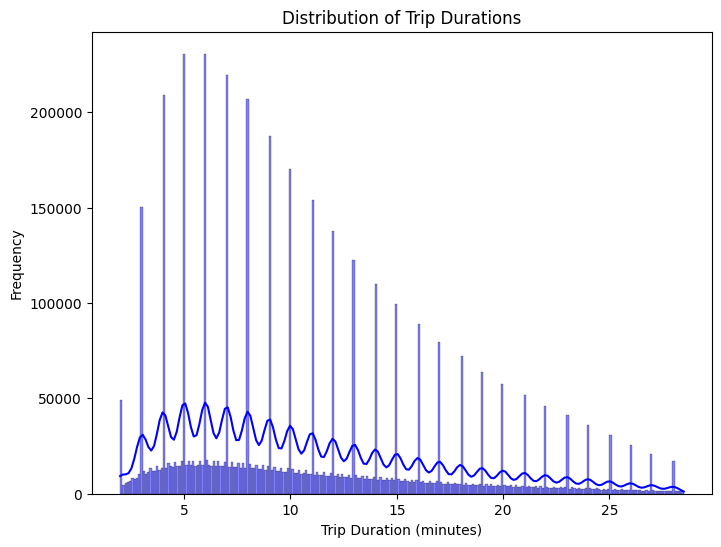

In [ ]:
# distribution of trip durations
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['trip_duration_minutes'] = (df['stoptime'] - df['starttime']).dt.total_seconds() / 60
plt.figure(figsize=(8,6))
sns.histplot(df['trip_duration_minutes'], kde=True, color='blue')
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

heavy tail, distribution is not normal

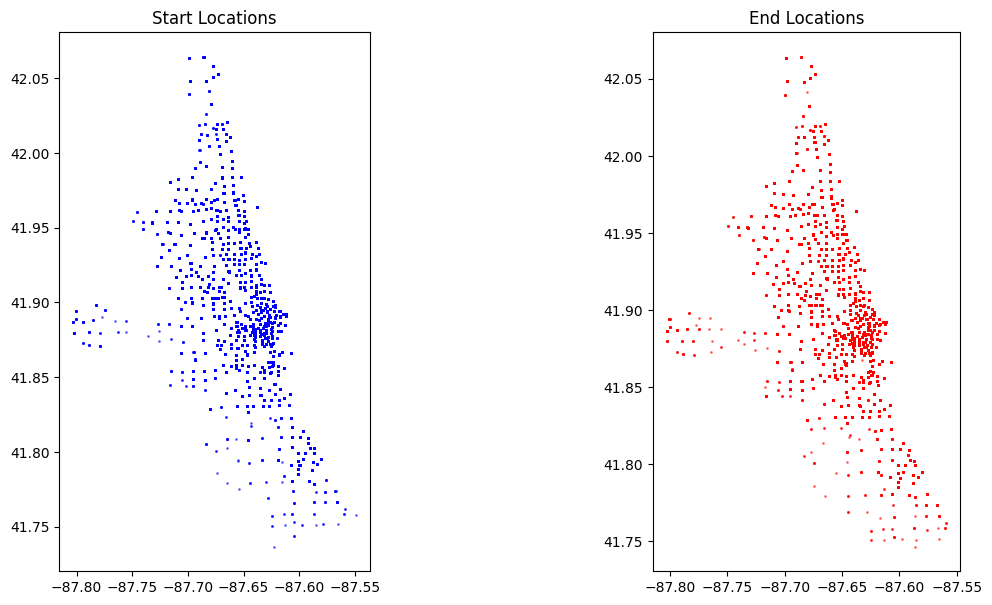

In [ ]:
"""if kde takes too long to run change data sample to 0.01"""

geometry_start = gpd.points_from_xy(df['longitude_start'], df['latitude_start'])
geometry_end = gpd.points_from_xy(df['longitude_end'], df['latitude_end'])
gdf_start = gpd.GeoDataFrame(df, geometry=geometry_start, crs="EPSG:4326")
gdf_end = gpd.GeoDataFrame(df, geometry=geometry_end, crs="EPSG:4326")

# visualize start and end points
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
gdf_start.plot(ax=ax[0], markersize=1, color='blue', alpha=0.5)
ax[0].set_title("Start Locations")
gdf_end.plot(ax=ax[1], markersize=1, color='red', alpha=0.5)
ax[1].set_title("End Locations")
plt.show()

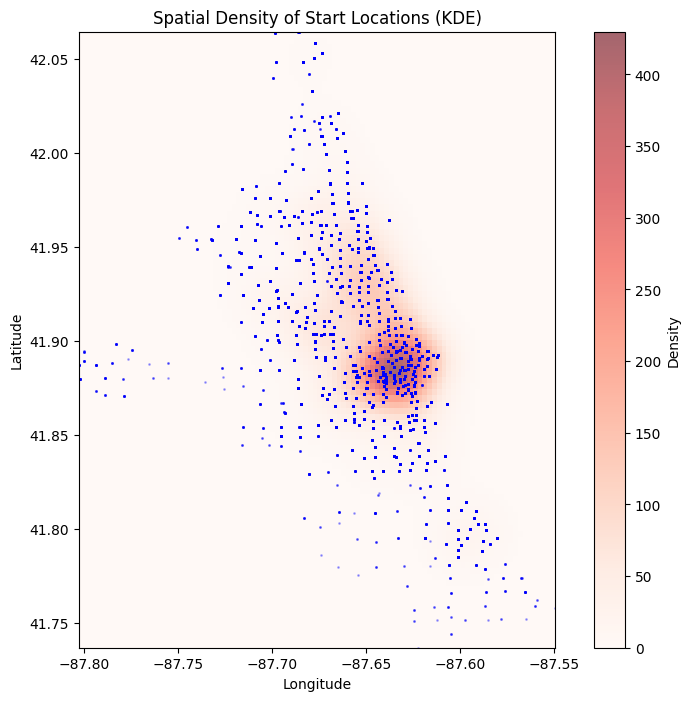

In [ ]:
coords = np.vstack([gdf_start.geometry.x, gdf_start.geometry.y]).T
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(coords)
x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
grid_coords = np.array([x_grid.ravel(), y_grid.ravel()]).T
z = np.exp(kde.score_samples(grid_coords)).reshape(x_grid.shape) # evaluate kde on grid
plt.figure(figsize=(10, 8))
plt.imshow(z, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='Reds', alpha=0.6)
plt.colorbar(label='Density')
plt.scatter(coords[:, 0], coords[:, 1], s=1, color='blue', alpha=0.3)
plt.title("Spatial Density of Start Locations (KDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

KDE density plot coincides with folium heatmap, indicating peak activity near Chicago downtown

Moran's I: 0.35431639430321016, p-value: 0.001


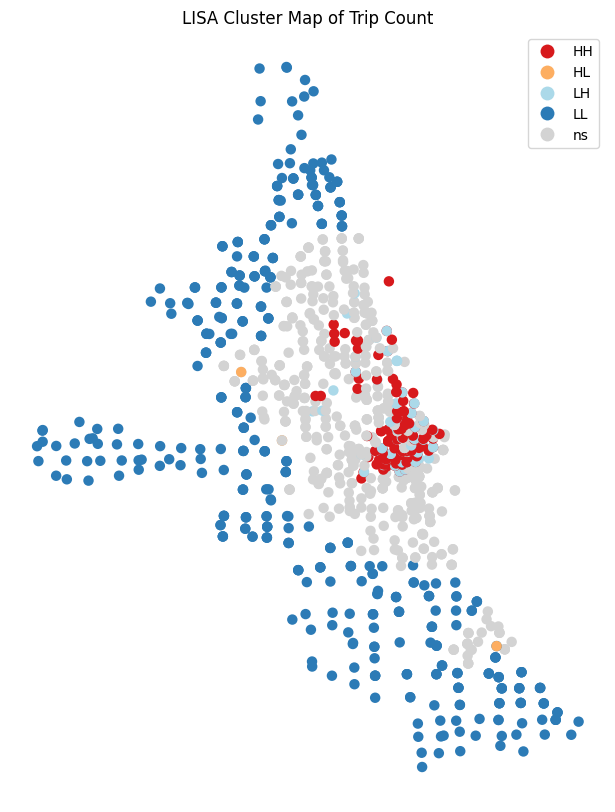

In [ ]:
# aggregate trip counts or average trip duration by location
gdf_counts = gdf_start.groupby(['latitude_start', 'longitude_start']).agg(
    trip_count=('trip_id', 'size'),
    avg_duration=('trip_duration_minutes', 'mean')
).reset_index()
gdf_counts = gpd.GeoDataFrame(
    gdf_counts,
    geometry=gpd.points_from_xy(gdf_counts['longitude_start'], gdf_counts['latitude_start']),
    crs="EPSG:4326"
)
#spatial weights matrix
weights = libpysal.weights.KNN.from_dataframe(gdf_counts, k=10)
# Moran's I (global autocorrelation)
moran = Moran(gdf_counts['trip_count'], weights)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")
# LISA
moran_local = Moran_Local(gdf_counts['trip_count'], weights)
# LISA cluster map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lisa_cluster(moran_local, gdf_counts, p=0.05, ax=ax)
plt.title("LISA Cluster Map of Trip Count")
plt.show()


Moran's I value of 0.35431639430321016 with a p-value of 0.001 indicates that there is a statistically significant positive spatial autocorrelation in the trip count data. This means that locations with similar trip counts tend to be clustered together in space.

Cluster types:
   - High-High clusters: areas with high trip counts surrounded by other areas with high trip counts. These are likely the most active hubs in the system.
   - Low-Low clusters: areas with low trip counts surrounded by other areas with low trip counts. These may be less utilized or less accessible areas.
   - High-Lowand Low-High clusters: spatial outliers, where an area with high trip counts is surrounded by areas with low trip counts, or vice versa.

This spatial clustering patterns actually can provide some insights for the Divvy marketing team, like:
- Identifying most popular stations that could benefit from additional capacity
- Detecting underserved areas with low trip counts that could be targeted for service expansion or marketing campaigns to increase ridership

In [ ]:
def create_spatial_analysis(df):

    geometry = [Point(xy) for xy in zip(df['longitude_start'], df['latitude_start'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    trip_lines = []
    for idx, row in df.iterrows():
        line = LineString([[row['longitude_start'], row['latitude_start']],
                         [row['longitude_end'], row['latitude_end']]])
        trip_lines.append(line)
    trips_gdf = gpd.GeoDataFrame(geometry=trip_lines)
    trips_gdf['hour'] = df['hour']
    trips_gdf['usertype'] = df['usertype']
    m = folium.Map(location=[df['latitude_start'].mean(),
                           df['longitude_start'].mean()],
                  zoom_start=12)
    heat_data = [[row['latitude_start'], row['longitude_start']] for idx, row in df.iterrows()]
    plugins.HeatMap(heat_data).add_to(m)


    def calculate_route_frequency(trips_gdf):
        route_counts = trips_gdf.geometry.apply(lambda x: tuple(x.coords)).value_counts()
        return gpd.GeoDataFrame(geometry=[LineString(coords) for coords in route_counts.index],
                              data={'frequency': route_counts.values})
    popular_routes = calculate_route_frequency(trips_gdf)
    temporal_patterns = df.groupby(['hour', 'usertype']).size().unstack()
    coords = df[['latitude_start', 'longitude_start']].values
    db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
    df['cluster'] = db.labels_
    return {
        'base_map': m,
        'popular_routes': popular_routes,
        'temporal_patterns': temporal_patterns,
        'spatial_clusters': df['cluster'].value_counts()
    }


def generate_insights(analysis_results):
    insights = []
    # popular routes
    top_routes = analysis_results['popular_routes'].nlargest(5, 'frequency')
    insights.append(f"Found {len(top_routes)} major bikeshare corridors")
    # temporal patterns
    peak_hour = analysis_results['temporal_patterns'].sum(axis=1).idxmax()
    insights.append(f"Peak usage occurs at {peak_hour}:00 hours")
    # clusters
    n_clusters = len(analysis_results['spatial_clusters'])
    insights.append(f"Identified {n_clusters} distinct spatial clusters of start locations")
    return insights

In [ ]:
create_spatial_analysis(df)

{'base_map': <folium.folium.Map at 0x7ae88dcb0fd0>,
 'popular_routes':        frequency                                           geometry
 0             72  LINESTRING (-87.63198 41.87817, -87.63983 41.8...
 1             68  LINESTRING (-87.61952 41.88473, -87.63983 41.8...
 2             66  LINESTRING (-87.61952 41.88473, -87.64117 41.8...
 3             58  LINESTRING (-87.64804 41.95438, -87.65441 41.9...
 4             58  LINESTRING (-87.65441 41.95424, -87.64804 41.9...
 ...          ...                                                ...
 41542          1  LINESTRING (-87.64952 41.95788, -87.65015 41.9...
 41543          1  LINESTRING (-87.61536 41.86723, -87.62412 41.8...
 41544          1  LINESTRING (-87.66851 41.92883, -87.64299 41.9...
 41545          1  LINESTRING (-87.63851 41.88918, -87.63983 41.8...
 41546          1  LINESTRING (-87.61752 41.88635, -87.61883 41.8...
 
 [41547 rows x 2 columns],
 'temporal_patterns': usertype  Customer  Subscriber
 hour               

In [ ]:
generate_insights(create_spatial_analysis(df))

['Found 5 major bikeshare corridors',
 'Peak usage occurs at 17:00 hours',
 'Identified 18 distinct spatial clusters of start locations']

In [ ]:
def cluster_analysis(df):
    """
    cluster analysis on bike trip origins and destinations
    """
    scaler = StandardScaler()
    X = df[['latitude_start', 'longitude_start', 'tripduration', 'day', 'hour']]
    X_scaled = scaler.fit_transform(X)
    # K-means
    kmeans = KMeans(n_clusters=18, random_state=42)
    df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=20)
    df['dbscan_label'] = dbscan.fit_predict(X_scaled)
    # plot both clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='longitude_start', y='latitude_start', hue='kmeans_cluster', data=df)
    plt.title('K-Means Clusters of Bike Trip Origins and Destinations')
    plt.show()
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='longitude_start', y='latitude_start', hue='dbscan_label', data=df)
    plt.title('DBSCAN Clusters of Bike Trip Origins and Destinations')
    plt.show()
    return df

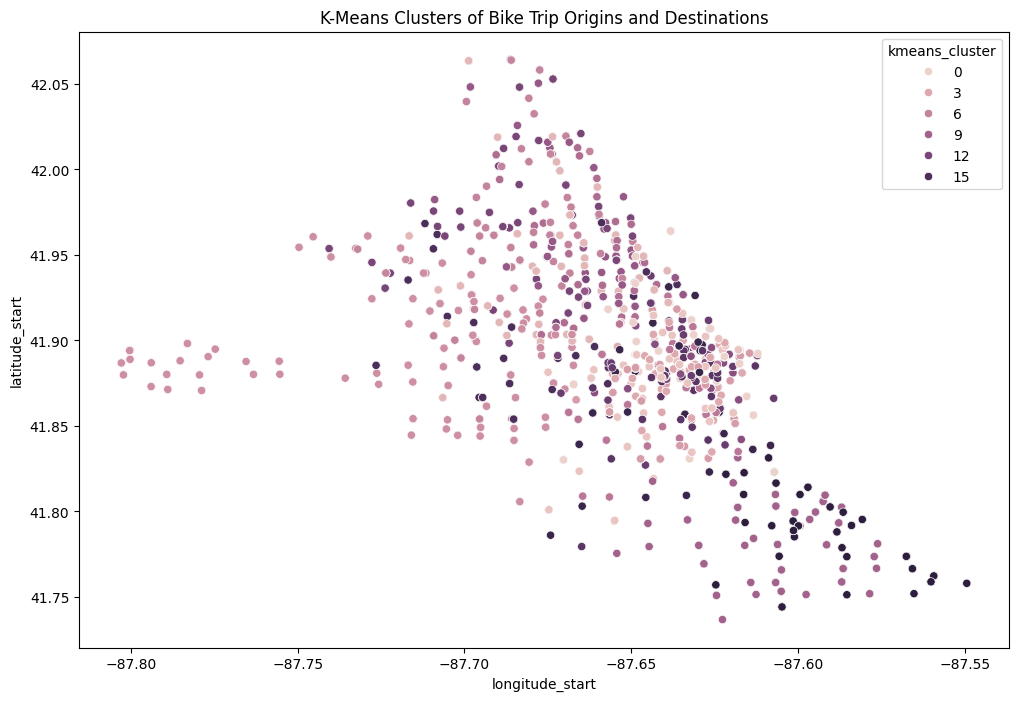

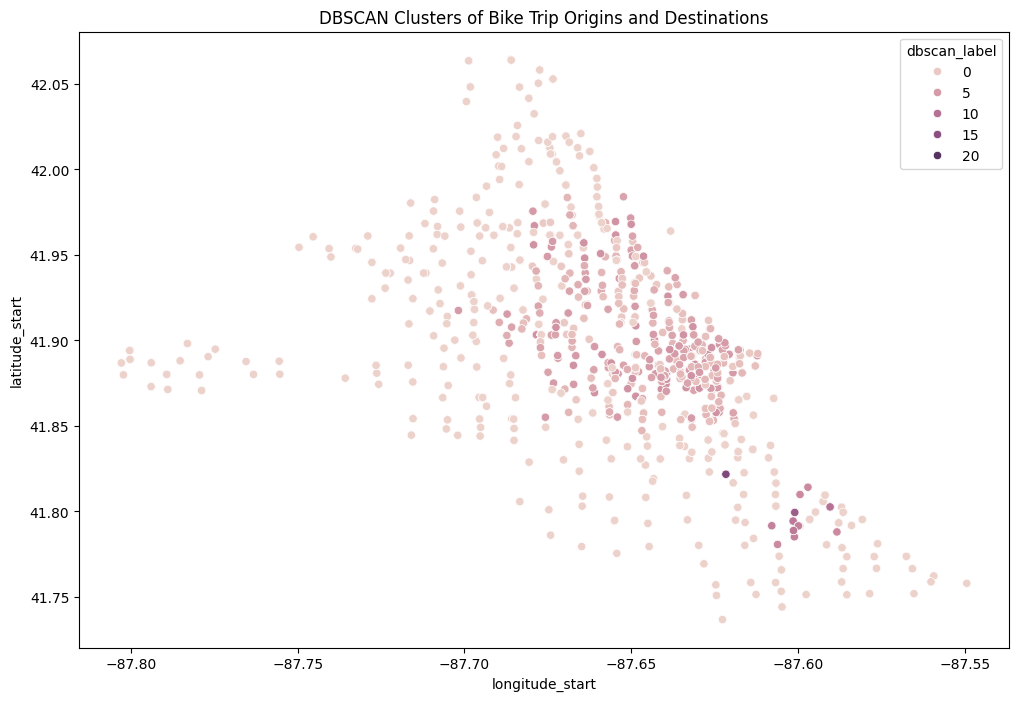

In [ ]:
df = cluster_analysis(df)

The clusters appear to be distributed in a somewhat scattered pattern, with some larger, denser clusters and some smaller, more dispersed clusters. This suggests that there are certain areas or neighborhoods that are more popular origins and destinations for bike trips, while other areas are less frequent.

K-Means, as a centroid-based algorithm, assumes that the clusters are spherical and have similar sizes. It will always assign each data point to one of the K clusters. DBSCAN, as a density-based algorithm, can identify clusters of arbitrary shape and size. It has identified a bigger number of distinct clusters compared to the K-Means, likely because the bike trip origins and destinations do not naturally form a fixed number of spherical clusters

In [ ]:
def plot_spatial_activity(df, group_col, group_values, output_directory):
    """
    Function to compare spatial activity between groups using heatmaps with distinct colors.

    Parameters:
    - df: DataFrame containing the cleaned data with latitude and longitude columns.
    - group_col: Column name to group by (e.g., 'usertype', 'gender', 'is_weekend').
    - group_values: List of values in the group_col to compare (e.g., ['Subscriber', 'Customer']).
    - output_directory: Directory path where output HTML maps will be saved.
    """
    for value in group_values:
        group_df = df[df[group_col] == value]
        m = folium.Map(location=[df['latitude_start'].mean(), df['longitude_start'].mean()], zoom_start=12)
        locations = group_df[['latitude_start', 'longitude_start']].values.tolist()
        heatmap = HeatMap(locations, name=f'{value} activity', radius=15, blur=10)
        heatmap.add_to(m)
        folium.Marker(
            location=[group_df['latitude_start'].mean(), group_df['longitude_start'].mean()],
            popup=f'{value} activity',
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)
        folium.LayerControl().add_to(m)
        output_path = f"{output_directory}/spatial_activity_by_{group_col}_{value}.html"
        m.save(output_path)
        print(f"Map comparing spatial activity for {group_col} = {value} saved to {output_path}")

# add weekend/weekday column
df['is_weekend'] = df['starttime'].dt.weekday >= 5  # true for weekends
output_directory = '/content/drive/My Drive'

# compare Customers vs. Subscribers
plot_spatial_activity(df, group_col='usertype', group_values=['Subscriber', 'Customer'], output_directory=output_directory)
# compare gender activity
plot_spatial_activity(df, group_col='gender', group_values=['Male', 'Female'], output_directory=output_directory)
# compare Weekend vs. Weekday activity
plot_spatial_activity(df, group_col='is_weekend', group_values=[True, False], output_directory=output_directory)

Map comparing spatial activity for usertype = Subscriber saved to /content/drive/My Drive/spatial_activity_by_usertype_Subscriber.html
Map comparing spatial activity for usertype = Customer saved to /content/drive/My Drive/spatial_activity_by_usertype_Customer.html
Map comparing spatial activity for gender = Male saved to /content/drive/My Drive/spatial_activity_by_gender_Male.html
Map comparing spatial activity for gender = Female saved to /content/drive/My Drive/spatial_activity_by_gender_Female.html
Map comparing spatial activity for is_weekend = True saved to /content/drive/My Drive/spatial_activity_by_is_weekend_True.html
Map comparing spatial activity for is_weekend = False saved to /content/drive/My Drive/spatial_activity_by_is_weekend_False.html


This peace of code should have generated 6 files on your machine, 2 for each group. We don't observe a distinct diffrence among gender activity. There are some noticeable differences in the bike share trip start location activity between weekends and weekdays in Chicago.

Weekend:
- high activity concentrated along the lakefront, particularly in the downtown and near north side areas. This suggests that on weekends, bike share trips are heavily focused on recreational and leisure activities
- significant activity in some of the neighborhoods west of downtown, such as West Town, Logan Square, and Humboldt Park. These areas are popular destinations for weekend activities, dining, and entertainment

Weekday:
- has a more dispersed pattern, with activity spread out across a broader area of the city. This indicates that on weekdays, bike share trips are more utilitarian in nature, likely for commuting to work, running errands, or accessing public transit
- heaviest concentrations of activity are still found in the downtown/central business district, as well as areas immediately surrounding it like the Near West Side and Near North Side
- less pronounced activity along the lakefront compared to the weekend, suggesting weekday bike share usage is more focused on practical transportation needs

 Customers, likely one-time users, take significantly fewer rides, with their activity concentrated in distinct clusters near downtown, resembling leisure-driven patterns. In contrast, subscribers account for the majority of trips in the dataset. The densest cluster for customers is near the Transportation Hub, suggesting that the marketing team should focus their advertisements and posters in this area, as well as consider expanding infrastructure there. This pattern also indicates that one-time customers are likely visitors to Chicago, as the heatmaps only include trip starting locations

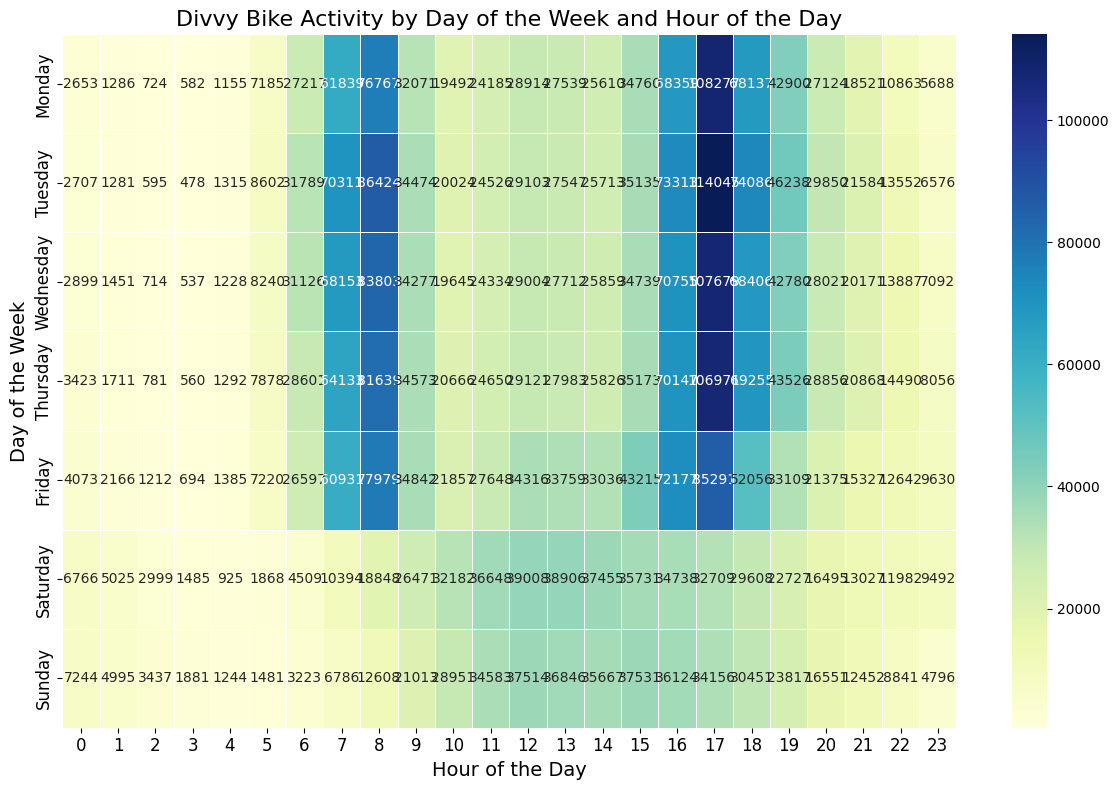

In [ ]:
#heatmap of the day to hour activity

df['starttime'] = pd.to_datetime(df['starttime'])
df['day_of_week'] = df['starttime'].dt.dayofweek  # Monday=0, Sunday=6
df['hour_of_day'] = df['starttime'].dt.hour
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week_name'] = df['day_of_week'].map(dict(enumerate(day_labels)))
#pivot table to calculate the count of trips for each day and hour
activity_matrix = df.pivot_table(index='day_of_week_name', columns='hour_of_day', values='trip_id', aggfunc='count', fill_value=0)
activity_matrix = activity_matrix.reindex(day_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(activity_matrix, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Divvy Bike Activity by Day of the Week and Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Day of the Week', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

As calculated before, peak activity occurs during 5 pm each weekday, with decreased activity during weekends

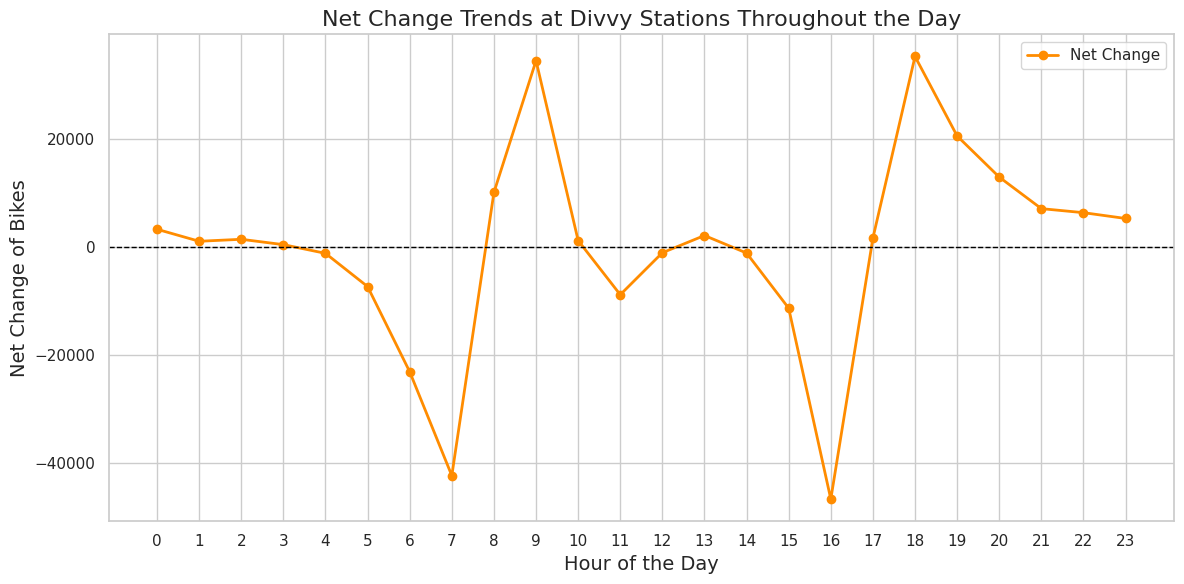

In [ ]:
#net gain/loss

df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['start_hour'] = df['starttime'].dt.hour
df['stop_hour'] = df['stoptime'].dt.hour
start_counts = df.groupby(['from_station_name', 'start_hour']).size().reset_index(name='departures')
end_counts = df.groupby(['to_station_name', 'stop_hour']).size().reset_index(name='arrivals')
# merge inflow (arrivals) and outflow (departures)
station_net_change = pd.merge(
    start_counts,
    end_counts,
    left_on=['from_station_name', 'start_hour'],
    right_on=['to_station_name', 'stop_hour'],
    how='outer'
)
station_net_change['departures'] = station_net_change['departures'].fillna(0)
station_net_change['arrivals'] = station_net_change['arrivals'].fillna(0)
station_net_change['net_change'] = station_net_change['arrivals'] - station_net_change['departures']
hourly_net_change = station_net_change.groupby('start_hour')['net_change'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
plt.plot(hourly_net_change['start_hour'], hourly_net_change['net_change'],
         marker='o', linestyle='-', color='darkorange', linewidth=2, label='Net Change')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Net Change Trends at Divvy Stations Throughout the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Net Change of Bikes', fontsize=14)
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()

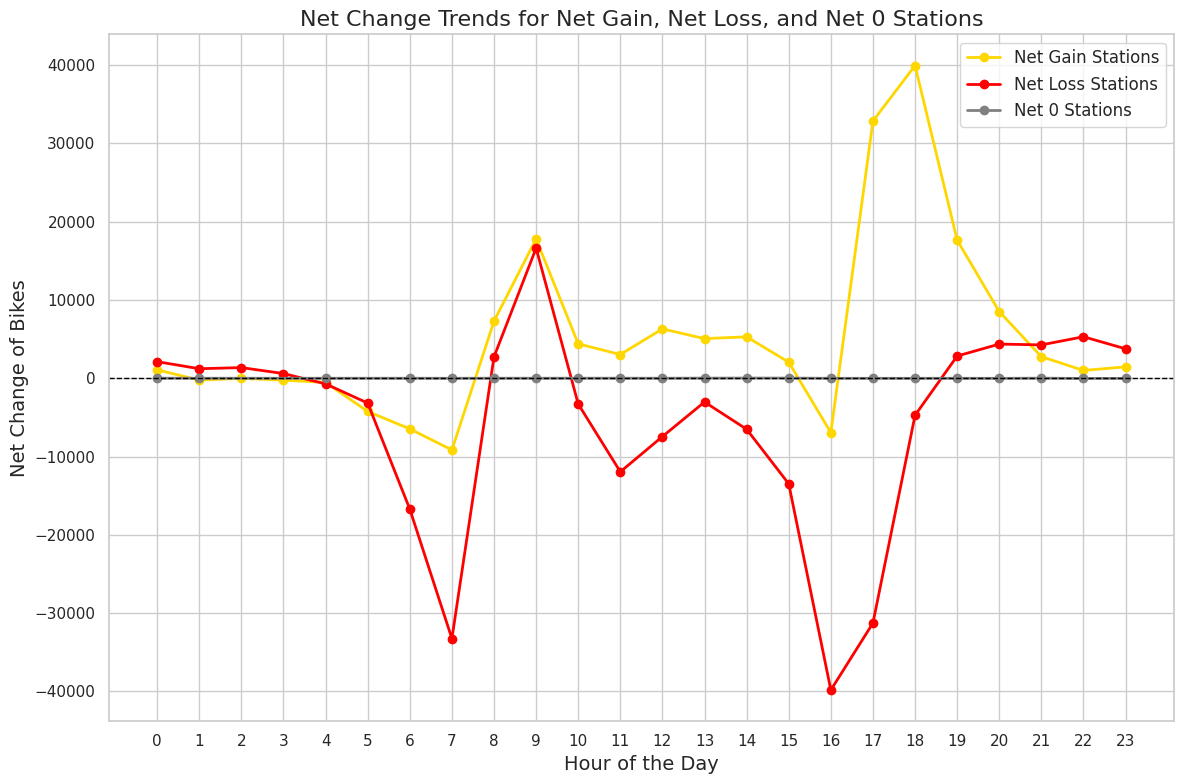

In [ ]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['start_hour'] = df['starttime'].dt.hour
df['stop_hour'] = df['stoptime'].dt.hour

start_counts = df.groupby(['from_station_name', 'start_hour']).size().reset_index(name='departures')
end_counts = df.groupby(['to_station_name', 'stop_hour']).size().reset_index(name='arrivals')
station_net_change = pd.merge(
    start_counts,
    end_counts,
    left_on=['from_station_name', 'start_hour'],
    right_on=['to_station_name', 'stop_hour'],
    how='outer'
)
station_net_change['departures'] = station_net_change['departures'].fillna(0)
station_net_change['arrivals'] = station_net_change['arrivals'].fillna(0)
station_net_change['net_change'] = station_net_change['arrivals'] - station_net_change['departures']
station_total_net = station_net_change.groupby('from_station_name')['net_change'].sum().reset_index()
station_total_net['category'] = station_total_net['net_change'].apply(
    lambda x: 'Net Gain' if x > 0 else ('Net Loss' if x < 0 else 'Net 0')
)
station_net_change = pd.merge(
    station_net_change,
    station_total_net[['from_station_name', 'category']],
    left_on='from_station_name',
    right_on='from_station_name'
)
net_gain = station_net_change[station_net_change['category'] == 'Net Gain']
net_loss = station_net_change[station_net_change['category'] == 'Net Loss']
net_zero = station_net_change[station_net_change['category'] == 'Net 0']
def plot_net_change(data, title, color):
    hourly_summary = data.groupby('start_hour')['net_change'].sum().reset_index()
    plt.plot(hourly_summary['start_hour'], hourly_summary['net_change'],
             marker='o', linestyle='-', color=color, linewidth=2, label=title)
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

plot_net_change(net_gain, 'Net Gain Stations', 'gold')
plot_net_change(net_loss, 'Net Loss Stations', 'red')
plot_net_change(net_zero, 'Net 0 Stations', 'gray')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Net Change Trends for Net Gain, Net Loss, and Net 0 Stations', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Net Change of Bikes', fontsize=14)
plt.xticks(range(0, 24))
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

**Net Gain Stations (Gold Line)**:  
   These stations consistently receive more bikes than they lose throughout the day. This pattern indicates that these stations serve as destination points—popular for tourists, leisure riders, or recreational cyclists.  Marketing teams can focus on these locations to promote bike-sharing services to tourists or occasional users. Increasing bike availability here during peak leisure hours will also improve user satisfaction.

**Net Loss Stations (Red Line)**:  
   These stations see a higher outflow of bikes in the mornings and an inflow in the afternoons. This pattern aligns with commuter behavior, where riders use bikes to travel from residential areas or transit hubs to downtown offices in the morning, and back in the evening. Again, downtown stations are high-demand zones for commuters, particularly during rush hours (early mornings and late afternoons).  


**Net 0 Stations (Gray Line)**:  
   These stations maintain a balance between bike inflow and outflow throughout the day. They likely cater to local, short round trips or low-demand areas where usage is consistent but modest.   🚲

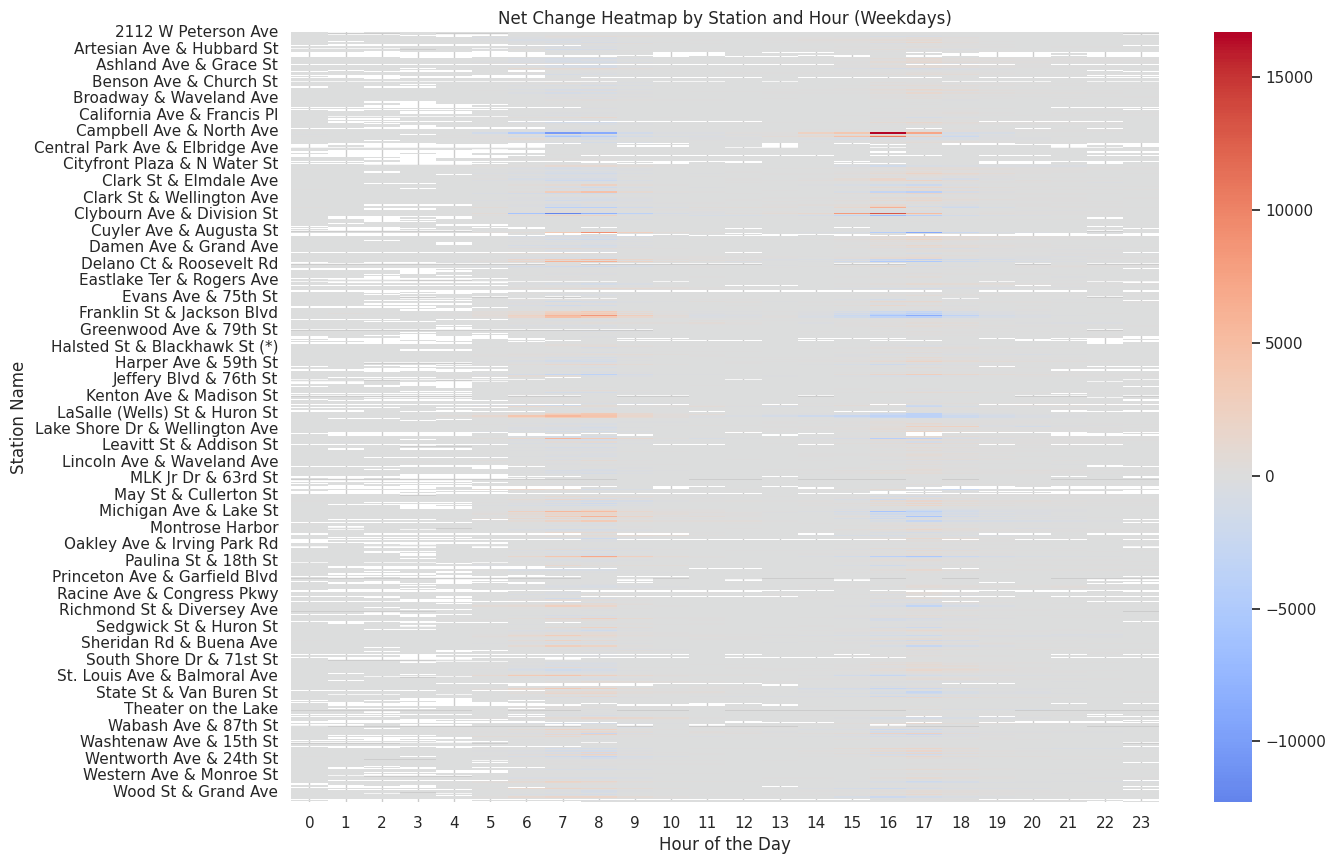

In [ ]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['start_hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek  # 0=Monday, 6=Sunday

def calculate_net_change(data):
    start_counts = data.groupby(['from_station_name', 'start_hour']).size().reset_index(name='departures')
    end_counts = data.groupby(['to_station_name', 'start_hour']).size().reset_index(name='arrivals')
    net_change = pd.merge(start_counts, end_counts,
                          left_on=['from_station_name', 'start_hour'],
                          right_on=['to_station_name', 'start_hour'],
                          how='outer')
    net_change['departures'] = net_change['departures'].fillna(0)
    net_change['arrivals'] = net_change['arrivals'].fillna(0)
    net_change['net_change'] = net_change['arrivals'] - net_change['departures']
    return net_change
weekday_df = df[df['day_of_week'] < 5]
weekday_net_change = calculate_net_change(weekday_df)
heatmap_data = weekday_net_change.pivot_table(index='from_station_name',
                                              columns='start_hour',
                                              values='net_change',
                                              aggfunc='sum')
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0)
plt.title('Net Change Heatmap by Station and Hour (Weekdays)')
plt.xlabel('Hour of the Day')
plt.ylabel('Station Name')
plt.show()

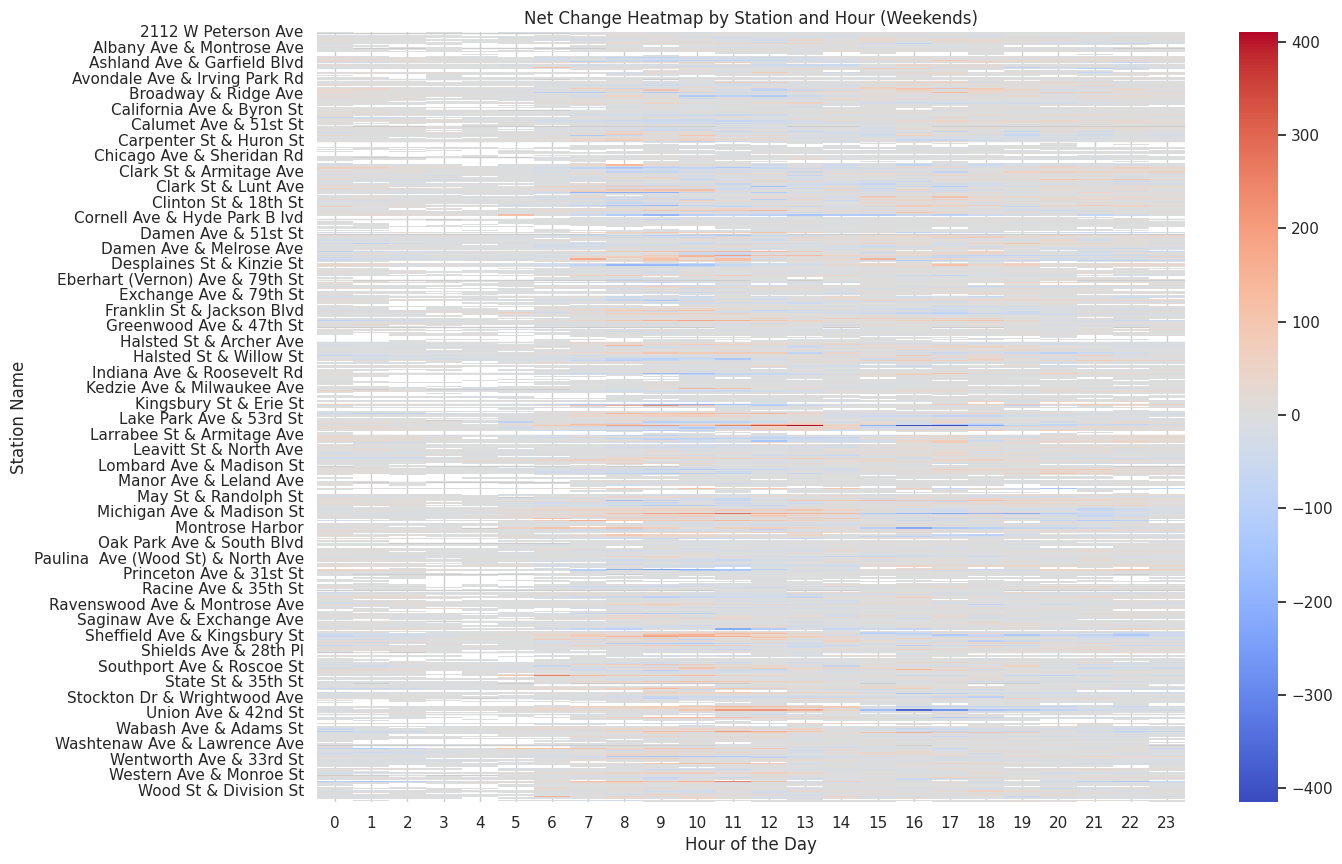

In [ ]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['start_hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek  # 0=Monday, 6=Sunday
def calculate_net_change(data):
    start_counts = data.groupby(['from_station_name', 'start_hour']).size().reset_index(name='departures')
    end_counts = data.groupby(['to_station_name', 'start_hour']).size().reset_index(name='arrivals')
    net_change = pd.merge(start_counts, end_counts,
                          left_on=['from_station_name', 'start_hour'],
                          right_on=['to_station_name', 'start_hour'],
                          how='outer')
    net_change['departures'] = net_change['departures'].fillna(0)
    net_change['arrivals'] = net_change['arrivals'].fillna(0)
    net_change['net_change'] = net_change['arrivals'] - net_change['departures']
    return net_change
weekday_df = df[df['day_of_week'] >= 5]
weekday_net_change = calculate_net_change(weekday_df)
heatmap_data = weekday_net_change.pivot_table(index='from_station_name',
                                              columns='start_hour',
                                              values='net_change',
                                              aggfunc='sum')
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0)
plt.title('Net Change Heatmap by Station and Hour (Weekends)')
plt.xlabel('Hour of the Day')
plt.ylabel('Station Name')
plt.show()

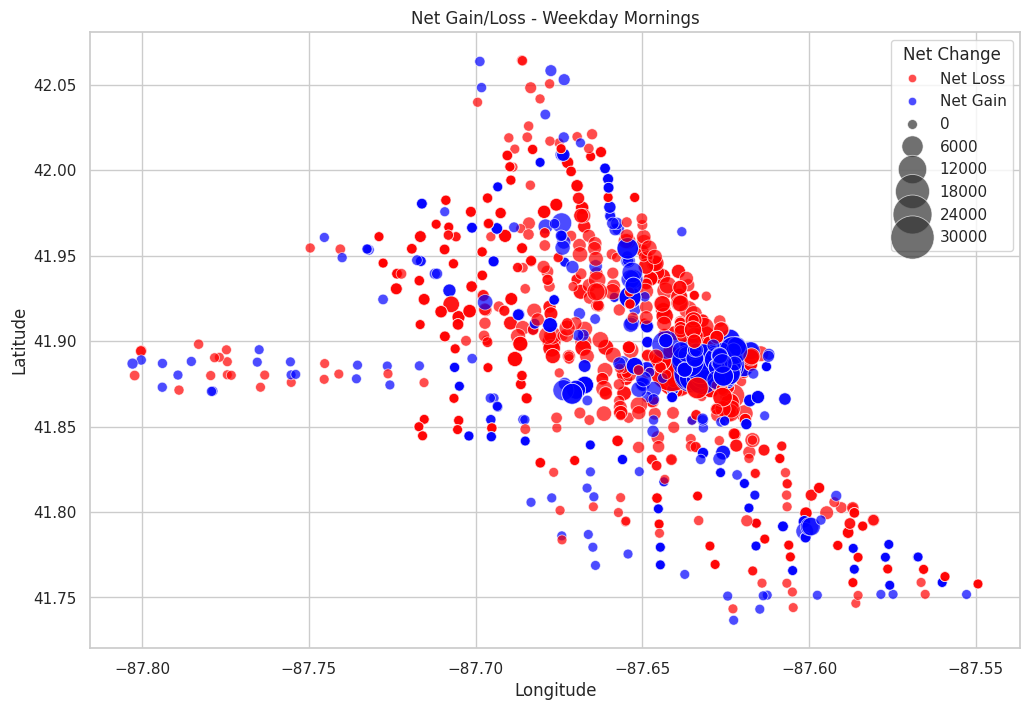

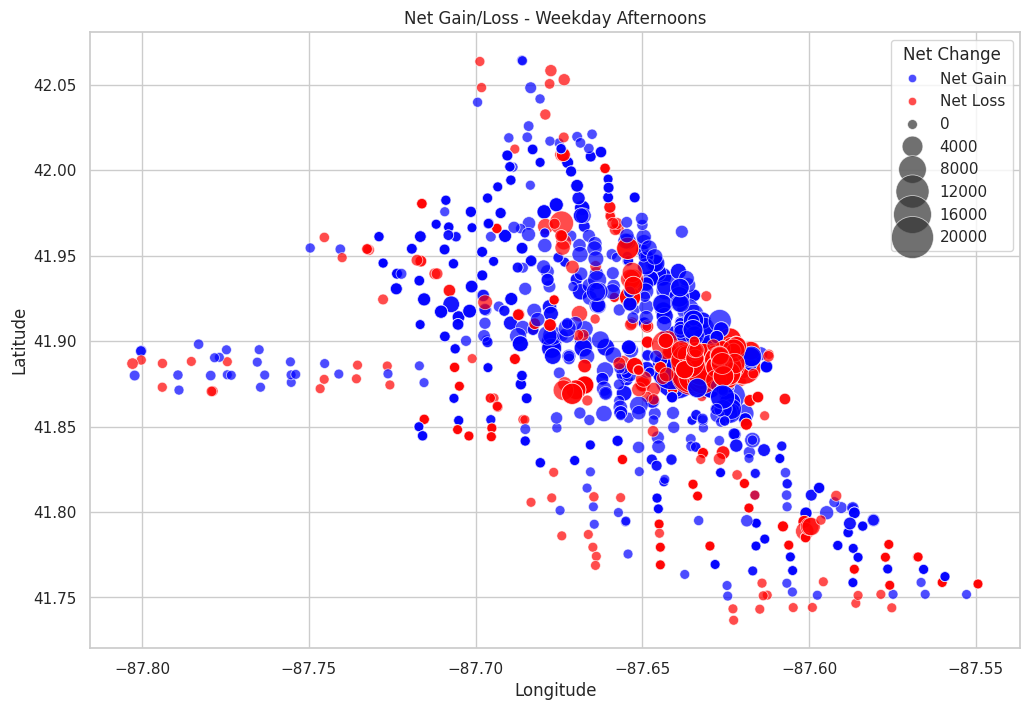

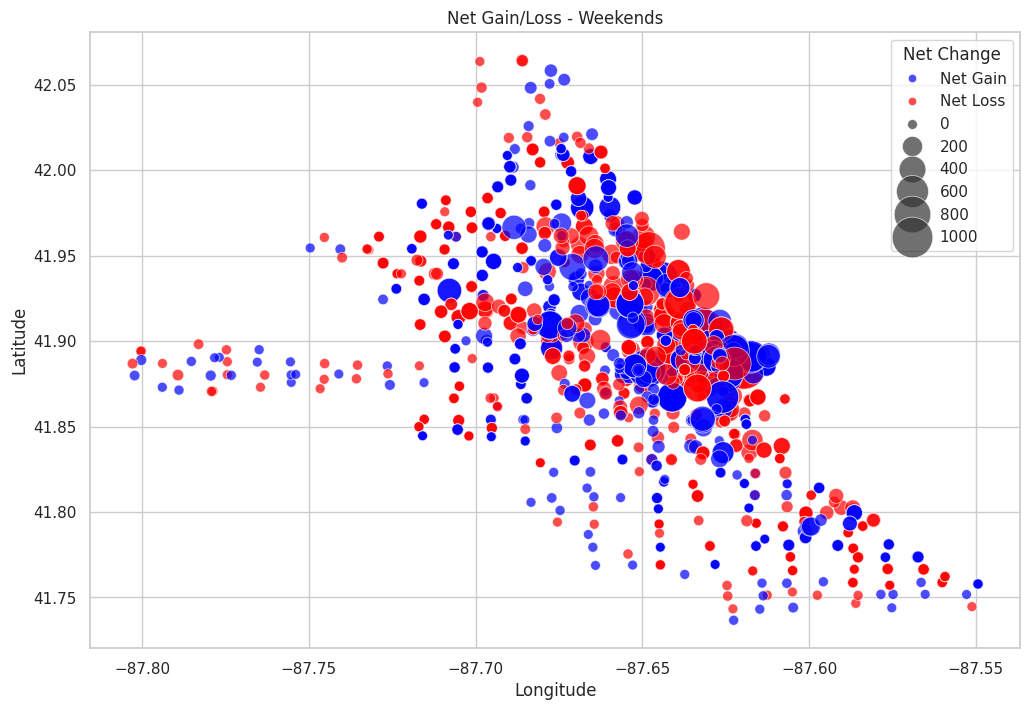

In [ ]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'] >= 5

def calculate_net_change(data, time_filter, time_name):
    filtered_data = data[time_filter]
    departures = filtered_data.groupby('from_station_name').size().reset_index(name='departures')
    arrivals = filtered_data.groupby('to_station_name').size().reset_index(name='arrivals')
    net_change = pd.merge(departures, arrivals,
                          left_on='from_station_name',
                          right_on='to_station_name',
                          how='outer').fillna(0)
    net_change['net_change'] = net_change['arrivals'] - net_change['departures']
    net_change['station_name'] = net_change['from_station_name'].combine_first(net_change['to_station_name'])
    start_coords = df[['from_station_name', 'latitude_start', 'longitude_start']].drop_duplicates()
    net_change = pd.merge(net_change, start_coords,
                          left_on='station_name',
                          right_on='from_station_name',
                          how='left')
    net_change = net_change.drop(columns=['from_station_name', 'to_station_name'], errors='ignore')
    return net_change, time_name

weekdays_morning = (df['day_of_week'] < 5) & (df['hour'].between(6, 10))
weekdays_afternoon = (df['day_of_week'] < 5) & (df['hour'].between(16, 19))
weekends = df['is_weekend']
weekdays_morning_data, scenario1 = calculate_net_change(df, weekdays_morning, "Weekday Mornings")
weekdays_afternoon_data, scenario2 = calculate_net_change(df, weekdays_afternoon, "Weekday Afternoons")
weekends_data, scenario3 = calculate_net_change(df, weekends, "Weekends")

def plot_bubble_map(data, title):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='longitude_start', y='latitude_start',
        size=abs(data['net_change']),  # bubble size is proportional to net change magnitude
        hue=np.where(data['net_change'] >= 0, 'Net Gain', 'Net Loss'),  # color based on net gain/loss
        palette={'Net Gain': 'blue', 'Net Loss': 'red'},
        sizes=(50, 1000),
        alpha=0.7,
        data=data
    )
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Net Change")
    plt.grid(True)
    plt.show()

plot_bubble_map(weekdays_morning_data, "Net Gain/Loss - Weekday Mornings")
plot_bubble_map(weekdays_afternoon_data, "Net Gain/Loss - Weekday Afternoons")
plot_bubble_map(weekends_data, "Net Gain/Loss - Weekends")

So, the first image shows that there is an influx of bikes in the morning (for weekdays) as commuters bike into the city center (Net gain concentrated in the downtown, while loss stations are scattered ourside of it).

The second image shows that bikes are being taken out of the city in the afternoon by commuters returning home (reversed Net Gain/Net Loss bubbles colors)

The third ikage shows tourist destinations on the weekend where there is high bike share usage, likely driven by leisure and recreational activities rather than commuting. Both net gain and loss are concentrated near downtown.

Together, these three panels illustrate the directional flows and imbalances in bike distribution across the city, with commuters driving activity patterns on weekdays and tourists/non-subscribers dominating on weekends.